Current Forest cost per project: £40
Forest cost per project to equalise TOTAL COST: £227.33
Forest cost per project to equalise £/t (mean): £245.30
Current Forest survival probability: 0.65
Forest survival probability to equalise £/t (mean): 0.107

Representative portfolio compositions and stats:

Low-Risk Portfolio
  DACS: 57
  Biochar: 8
  Forest: 0
  Mean = 31,415 tCO₂
  SD   = 679 tCO₂
  Cost = £23,760
  Forest Share = 0.0%
  CaR  = 2,500 tCO₂

Medium-Risk Portfolio
  DACS: 20
  Biochar: 19
  Forest: 47
  Mean = 32,775 tCO₂
  SD   = 1,866 tCO₂
  Cost = £12,160
  Forest Share = 54.7%
  CaR  = 13,000 tCO₂

Higher-Risk Portfolio
  DACS: 2
  Biochar: 0
  Forest: 101
  Mean = 33,815 tCO₂
  SD   = 2,397 tCO₂
  Cost = £4,840
  Forest Share = 98.1%
  CaR  = 21,500 tCO₂


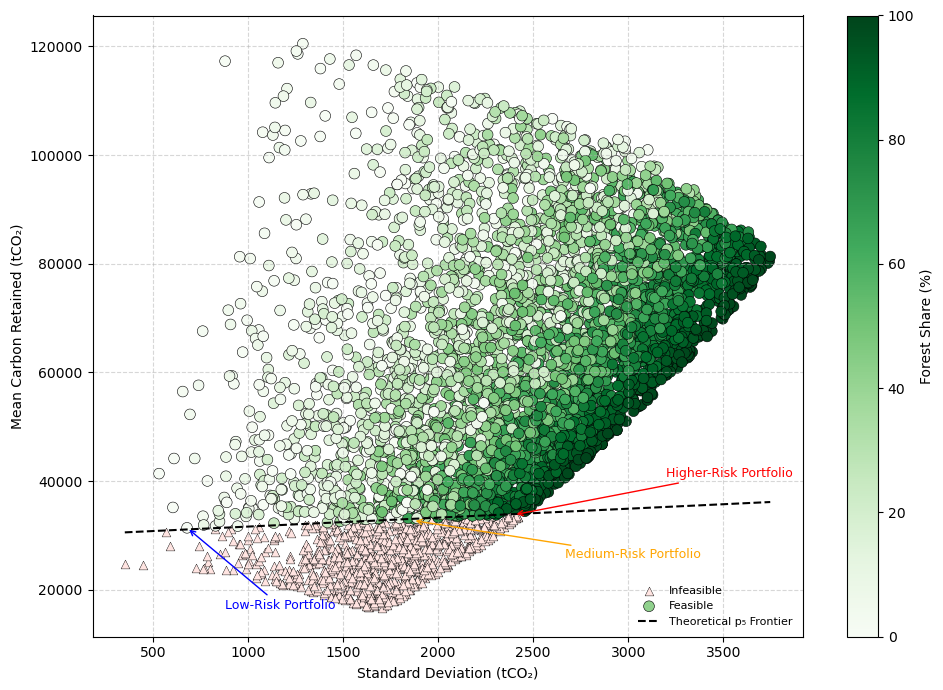

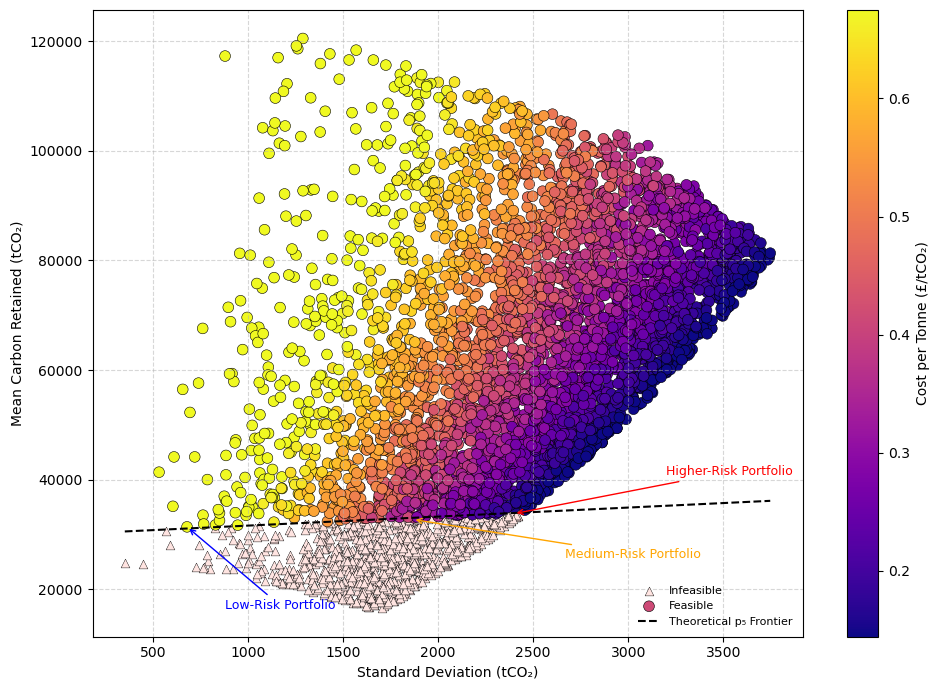

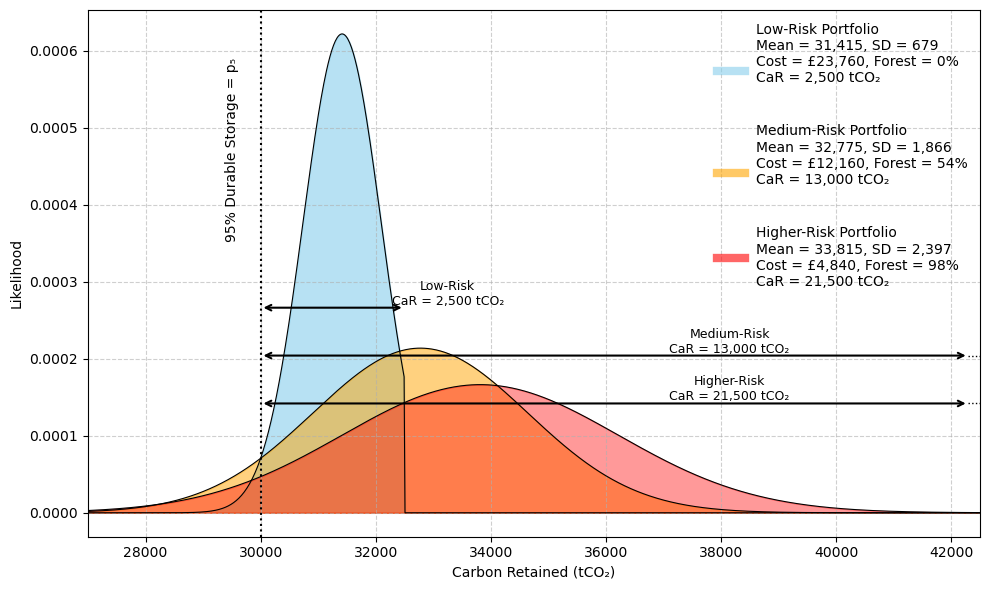

In [11]:
# === Portfolio Simulation and Plotting Script (Nature-style Risk Analysis) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import random
from scipy.stats import truncnorm

# Simulation Parameters
project_tonnes = 500
p5_threshold = 30000
n_portfolios = 5000
project_costs = {"DACS": 400, "Biochar": 120, "Forest": 40}
survival_probs = {"DACS": 0.99, "Biochar": 0.8, "Forest": 0.65}

# Set Seed
random.seed(123)
np.random.seed(123)

# Simulate portfolios
portfolios = []
for _ in range(n_portfolios):
    total = random.randint(50, 250)
    f = random.randint(0, total)
    remaining = total - f
    d = random.randint(0, remaining)
    b = remaining - d

    mean = (
        d * survival_probs["DACS"]
        + b * survival_probs["Biochar"]
        + f * survival_probs["Forest"]
    )
    var = (
        d * survival_probs["DACS"] * (1 - survival_probs["DACS"])
        + b * survival_probs["Biochar"] * (1 - survival_probs["Biochar"])
        + f * survival_probs["Forest"] * (1 - survival_probs["Forest"])
    )

    mean *= project_tonnes
    sd = np.sqrt(var) * project_tonnes
    p5 = mean - 1.645 * sd
    cost = d * project_costs["DACS"] + b * project_costs["Biochar"] + f * project_costs["Forest"]
    cost_per_tonne = cost / mean if mean > 0 else np.nan
    forest_share = 100 * f / total if total > 0 else 0

    portfolios.append({
        "DACS": d, "Biochar": b, "Forest": f, "Total Projects": total,
        "Mean": mean, "SD": sd, "p5": p5,
        "Feasible": p5 >= p5_threshold,
        "EdgeP5": p5_threshold * 0.99 <= p5 <= p5_threshold * 1.01,
        "Forest Share": forest_share,
        "Cost": cost, "Cost per Tonne": cost_per_tonne
    })

df = pd.DataFrame(portfolios)
df_feasible = df[df["Feasible"]]
df_infeasible = df[~df["Feasible"]]
df_edge = df[df["EdgeP5"]]

# Select representative portfolios (low, medium, high forest share)
df_edge_sorted = df_edge.sort_values("Forest Share")
portfolio_low = df_edge_sorted.iloc[0]
portfolio_medium = df_edge_sorted.iloc[len(df_edge_sorted)//2]
portfolio_high = df_edge_sorted.iloc[-1]

# === Plot 1: Forest Share ===
fig1, ax1 = plt.subplots(figsize=(10, 7))
norm1 = Normalize(vmin=df["Forest Share"].min(), vmax=df["Forest Share"].max())
cmap1 = plt.get_cmap("Greens")

ax1.scatter(df_infeasible["SD"], df_infeasible["Mean"], c="mistyrose", s=40,
            edgecolors="black", linewidths=0.3, marker='^', label="Infeasible")
sc1 = ax1.scatter(df_feasible["SD"], df_feasible["Mean"],
                  c=df_feasible["Forest Share"], cmap=cmap1, norm=norm1,
                  s=60, edgecolors="black", linewidths=0.4, marker='o', label="Feasible")

x_vals = np.linspace(df["SD"].min(), df["SD"].max(), 200)
y_vals = p5_threshold + 1.645 * x_vals
ax1.plot(x_vals, y_vals, linestyle="dashed", color="black", linewidth=1.5, label="Theoretical p₅ Frontier")

# Annotate three portfolios

for label, p, dx, dy, color in [
    ("Low-Risk", portfolio_low, +200, -15000, "blue"),
    ("Medium-Risk", portfolio_medium, +800, -7000, "orange"),
    ("Higher-Risk", portfolio_high, +800, +7000, "red")
]:
    ax1.annotate(f"{label} Portfolio",
                 xy=(p["SD"], p["Mean"]),
                 xytext=(p["SD"]+dx, p["Mean"]+dy),
                 arrowprops=dict(arrowstyle="->", lw=1, color=color),
                 fontsize=9, color=color, ha="left")

sm1 = ScalarMappable(norm=norm1, cmap=cmap1)
sm1.set_array([])
cbar1 = fig1.colorbar(sm1, ax=ax1)
cbar1.set_label("Forest Share (%)")

ax1.set_xlabel("Standard Deviation (tCO₂)")
ax1.set_ylabel("Mean Carbon Retained (tCO₂)")
ax1.legend(frameon=False, loc="lower right", fontsize=8)
ax1.grid(True, linestyle="--", alpha=0.5)
fig1.tight_layout()
fig1.savefig("fig1_forest_share.png", dpi=300)

# === Plot 2: Cost per Tonne ===
fig2, ax2 = plt.subplots(figsize=(10, 7))
norm2 = Normalize(vmin=df["Cost per Tonne"].quantile(0.05), vmax=df["Cost per Tonne"].quantile(0.95))
cmap2 = plt.get_cmap("plasma")

ax2.scatter(df_infeasible["SD"], df_infeasible["Mean"], c="mistyrose", s=40,
            edgecolors="black", linewidths=0.3, marker='^', label="Infeasible")
sc2 = ax2.scatter(df_feasible["SD"], df_feasible["Mean"],
                  c=df_feasible["Cost per Tonne"], cmap=cmap2, norm=norm2,
                  s=60, edgecolors="black", linewidths=0.4, marker='o', label="Feasible")

ax2.plot(x_vals, y_vals, linestyle="dashed", color="black", linewidth=1.5, label="Theoretical p₅ Frontier")

# Annotate three portfolios
for label, p, dx, dy, color in [
    ("Low-Risk", portfolio_low, +200, -15000, "blue"),
    ("Medium-Risk", portfolio_medium, +800, -7000, "orange"),
    ("Higher-Risk", portfolio_high, +800, +7000, "red")
]:
    ax2.annotate(f"{label} Portfolio",
                 xy=(p["SD"], p["Mean"]),
                 xytext=(p["SD"]+dx, p["Mean"]+dy),
                 arrowprops=dict(arrowstyle="->", lw=1, color=color),
                 fontsize=9, color=color, ha="left")

sm2 = ScalarMappable(norm=norm2, cmap=cmap2)
sm2.set_array([])
cbar2 = fig2.colorbar(sm2, ax=ax2)
cbar2.set_label("Cost per Tonne (£/tCO₂)")

ax2.set_xlabel("Standard Deviation (tCO₂)")
ax2.set_ylabel("Mean Carbon Retained (tCO₂)")
ax2.legend(frameon=False, loc="lower right", fontsize=8)
ax2.grid(True, linestyle="--", alpha=0.5)
fig2.tight_layout()
fig2.savefig("fig2_cost_per_tonne.png", dpi=300)

# === Plot 3: Likelihood Curves with truncated normals ===
def trunc_pdf(x, mean, sd, lo, hi):
    a, b = (lo - mean)/sd, (hi - mean)/sd
    return truncnorm.pdf(x, a=a, b=b, loc=mean, scale=sd)

x = np.linspace(27000, 42500, 1000)

# Potentials (all projects succeed)
pot_low = (portfolio_low["DACS"] + portfolio_low["Biochar"] + portfolio_low["Forest"]) * project_tonnes
pot_med = (portfolio_medium["DACS"] + portfolio_medium["Biochar"] + portfolio_medium["Forest"]) * project_tonnes
pot_high = (portfolio_high["DACS"] + portfolio_high["Biochar"] + portfolio_high["Forest"]) * project_tonnes

# PDFs (truncated normals)
pdf_low = trunc_pdf(x, mean=portfolio_low["Mean"], sd=portfolio_low["SD"], lo=0, hi=pot_low)
pdf_med = trunc_pdf(x, mean=portfolio_medium["Mean"], sd=portfolio_medium["SD"], lo=0, hi=pot_med)
pdf_high = trunc_pdf(x, mean=portfolio_high["Mean"], sd=portfolio_high["SD"], lo=0, hi=pot_high)

plt.figure(figsize=(10, 6))
plt.fill_between(x, pdf_low, color="skyblue", alpha=0.6)
plt.fill_between(x, pdf_med, color="orange", alpha=0.5)
plt.fill_between(x, pdf_high, color="red", alpha=0.4)
plt.plot(x, pdf_low, color="black", lw=0.8)
plt.plot(x, pdf_med, color="black", lw=0.8)
plt.plot(x, pdf_high, color="black", lw=0.8)

# Common p5 threshold line
plt.axvline(p5_threshold, color="black", linestyle="dotted", lw=1.5)
ymax = max(pdf_low.max(), pdf_med.max(), pdf_high.max())
plt.text(p5_threshold - 500, 0.95*ymax, "95% Durable Storage = p₅",
         rotation=90, va="top", ha="center", fontsize=10, color="black")

# CaR arrows and labels
for label, p, potential, color, y_frac in [
    ("Low-Risk", portfolio_low, pot_low, "skyblue", 0.75),
    ("Medium-Risk", portfolio_medium, pot_med, "orange", 0.65),
    ("Higher-Risk", portfolio_high, pot_high, "red", 0.55)
]:
    CAR = potential - p5_threshold
    
    if "Medium-Risk" in label:
        y_annot = 30000   # fixed position for medium-risk label
    else:
        y_annot = y_frac*ymax - 0.0002
    
    arrow_end = min(potential, 42500-200)


for label, p, potential, color, y_frac in [
    ("Low-Risk", portfolio_low, pot_low, "skyblue", 0.75),
    ("Medium-Risk", portfolio_medium, pot_med, "orange", 0.65),
    ("Higher-Risk", portfolio_high, pot_high, "red", 0.55)
]:
    CAR = potential - p5_threshold
    y_annot = y_frac*ymax - 0.0002
    arrow_end = min(potential, 42500-200)

    # Main arrow
    plt.annotate("", xy=(p5_threshold, y_annot), xytext=(arrow_end, y_annot),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # If potential exceeds axis cap, show dotted continuation
    if potential > 42500-200:
        plt.plot([arrow_end, 42500], [y_annot, y_annot],
                 linestyle=":", color="black", lw=1)

    # Text label
    plt.text((p5_threshold + arrow_end)/2 + 2000, y_annot,
             f"{label}\nCaR = {int(CAR):,} tCO₂",
             ha="center", va="bottom", color="black", fontsize=9)

# Legend entries (dummy artists with stats + CaR)
CAR_low = int(pot_low - p5_threshold)
CAR_med = int(pot_med - p5_threshold)
CAR_high = int(pot_high - p5_threshold)

label_low = (
    "Low-Risk Portfolio\n"
    f"Mean = {int(portfolio_low['Mean']):,}, SD = {int(portfolio_low['SD']):,}\n"
    f"Cost = £{int(portfolio_low['Cost']):,}, Forest = {int(portfolio_low['Forest Share']):.0f}%\n"
    f"CaR = {CAR_low:,} tCO₂"
)

label_med = (
    "Medium-Risk Portfolio\n"
    f"Mean = {int(portfolio_medium['Mean']):,}, SD = {int(portfolio_medium['SD']):,}\n"
    f"Cost = £{int(portfolio_medium['Cost']):,}, Forest = {int(portfolio_medium['Forest Share']):.0f}%\n"
    f"CaR = {CAR_med:,} tCO₂"
)

label_high = (
    "Higher-Risk Portfolio\n"
    f"Mean = {int(portfolio_high['Mean']):,}, SD = {int(portfolio_high['SD']):,}\n"
    f"Cost = £{int(portfolio_high['Cost']):,}, Forest = {int(portfolio_high['Forest Share']):.0f}%\n"
    f"CaR = {CAR_high:,} tCO₂"
)

plt.plot([], [], color="skyblue", linewidth=6, alpha=0.6, label=label_low + "\n\n")
plt.plot([], [], color="orange", linewidth=6, alpha=0.6, label=label_med + "\n\n")
plt.plot([], [], color="red", linewidth=6, alpha=0.6, label=label_high)

plt.legend(frameon=False, loc="upper right")
plt.xlabel("Carbon Retained (tCO₂)")
plt.ylabel("Likelihood")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(27000, 42500)
plt.tight_layout()
plt.savefig("fig3_portfolio_likelihoods.png", dpi=300)


# === Forest equalisation helper ===
def forest_equalisation(portfolio_L, portfolio_B, costs, surv_probs, project_tonnes=500):
    dL, bL, fL = portfolio_L["DACS"], portfolio_L["Biochar"], portfolio_L["Forest"]
    dB, bB, fB = portfolio_B["DACS"], portfolio_B["Biochar"], portfolio_B["Forest"]

    cD, cB, cF = costs["DACS"], costs["Biochar"], costs["Forest"]
    pD, pB, pF = surv_probs["DACS"], surv_probs["Biochar"], surv_probs["Forest"]

    cost_L = dL*cD + bL*cB + fL*cF
    mu_L   = project_tonnes*(dL*pD + bL*pB + fL*pF)
    CPT_L  = cost_L / mu_L

    cost_B_fixed = dB*cD + bB*cB
    mu_B   = project_tonnes*(dB*pD + bB*pB + fB*pF)

    cF_equal_total = (cost_L - cost_B_fixed) / fB if fB > 0 else float("nan")
    cF_equal_cpt   = (CPT_L*mu_B - cost_B_fixed) / fB if fB > 0 else float("nan")

    numerator = (cost_B_fixed + fB*cF)
    target_denom = numerator / CPT_L / project_tonnes
    pF_equal_cpt = (target_denom - (dB*pD + bB*pB)) / fB if fB > 0 else float("nan")

    return {"forest_price_equal_total": cF_equal_total,
            "forest_price_equal_cpt": cF_equal_cpt,
            "forest_survival_equal_cpt": pF_equal_cpt}

# Wrap two portfolios for comparison (e.g. Low vs Higher Risk)
portfolio_L = {"DACS": int(portfolio_low["DACS"]),
               "Biochar": int(portfolio_low["Biochar"]),
               "Forest": int(portfolio_low["Forest"])}
portfolio_B = {"DACS": int(portfolio_high["DACS"]),
               "Biochar": int(portfolio_high["Biochar"]),
               "Forest": int(portfolio_high["Forest"])}

results = forest_equalisation(portfolio_L, portfolio_B, project_costs, survival_probs)

current_forest_cost = project_costs["Forest"]
current_forest_surv = survival_probs["Forest"]

print(f"Current Forest cost per project: £{current_forest_cost}")
print(f"Forest cost per project to equalise TOTAL COST: £{results['forest_price_equal_total']:.2f}")
print(f"Forest cost per project to equalise £/t (mean): £{results['forest_price_equal_cpt']:.2f}")
print(f"Current Forest survival probability: {current_forest_surv:.2f}")
print(f"Forest survival probability to equalise £/t (mean): {results['forest_survival_equal_cpt']:.3f}")

# === Print compositions and key stats for representative portfolios ===
print("\nRepresentative portfolio compositions and stats:")
for label, p in [("Low-Risk", portfolio_low),
                 ("Medium-Risk", portfolio_medium),
                 ("Higher-Risk", portfolio_high)]:
    print(f"\n{label} Portfolio")
    print(f"  DACS: {int(p['DACS'])}")
    print(f"  Biochar: {int(p['Biochar'])}")
    print(f"  Forest: {int(p['Forest'])}")
    print(f"  Mean = {int(p['Mean']):,} tCO₂")
    print(f"  SD   = {int(p['SD']):,} tCO₂")
    print(f"  Cost = £{int(p['Cost']):,}")
    print(f"  Forest Share = {p['Forest Share']:.1f}%")
    CAR = (p['DACS'] + p['Biochar'] + p['Forest']) * project_tonnes - p5_threshold
    print(f"  CaR  = {int(CAR):,} tCO₂")
